In [21]:
from urllib.request import urlopen
from pathlib import Path
import json
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from IPython.display import display
from plotly.offline import plot

%load_ext rpy2.ipython

# EDA of Opioid-Crisis-Adjacent Factors

## County-Level Drug-Related Deaths

We take a look at drug poisoning mortality by county. The relevant dataset is cited in this [NYTimes Article](https://www.nytimes.com/interactive/2016/01/07/us/drug-overdose-deaths-in-the-us.html) and can be [found on the CDC website here](https://www.cdc.gov/nchs/data-visualization/drug-poisoning-mortality/).

In [ ]:
# import county-level overdose counts 
od_path = Path('data/NCHS_-_Drug_Poisoning_Mortality_by_County__United_States.csv')
county_od = pd.read_csv(od_path, dtype={'FIPS': str})

# pad FIPS code to 5 digits 
county_od['FIPS'] = county_od['FIPS'].str.pad(5, side='left', fillchar='0')

county_od.head()

There are a few limitations of the dataset: first, the death rate is not raw data and is the result of some modeling already.  **This suggests that we may need to propogate errors if we decide to include this data in our models**.  Second, the death count is based on drug overdoses across all categories of drugs, so it does not provide heroin- or opioid-specific data.

However, given that opioids are responsible for a majority of fatal drug overdoses, taking a look at this dataset should still provide some insight into how opioid-specific overdoses are changing over time. 

In [ ]:
# check for missing values
display('Number of missing values in each column:', 
        county_od.isnull().sum())

# explore range of values
display('Earliest year:', 
        county_od['Year'].min(), 'Latest year:', county_od['Year'].max())
display('States included:', 
        county_od['State'].unique(), 'Number of states:', len(county_od['State'].unique())) 
display('Urban/Rural Categories:', 
        county_od['Urban/Rural Category'].unique())

# are observations unique by FIPS and year? 
display('Number of duplicated observations by FIPS code and year:',
        county_od[['FIPS', 'Year']].duplicated().sum())

# are all years available for each county? 
display('Number of counties without 16 years of data:',
        (county_od.groupby('FIPS')['Year'].count() != 16).sum())

The benefit of the death rates already having gone through some processing is that the dataset is very complete. In the following, we explore how death rates have changed by 'Urban/Rural Category'. 

In [ ]:
year = county_od.groupby('Year', as_index=False)['Model-based Death Rate'].mean()
year['Urban/Rural Category'] = 'Overall'

year_urban = county_od.groupby(['Year', 'Urban/Rural Category'], as_index=False)
year_urban = year_urban['Model-based Death Rate'].mean()
year_urban = pd.concat([year, year_urban], ignore_index=True)

dash_spec = {type: (2,2) for type in county_od['Urban/Rural Category'].unique()}
dash_spec['Overall'] = ''

sns.relplot(x='Year', y='Model-based Death Rate',
            hue='Urban/Rural Category', style='Urban/Rural Category',
            dashes=dash_spec,
            kind='line', 
            height=7, data=year_urban)
plt.title('Average County-level Death Rate (per 100,000) by Urban/Rural Category',
          pad = 20);


Interestingly, up until 2016, the growth of the average county-level death rate seems to be fairly comparable across urban/rural classifications. We also explore the growth of deaths by year and state. 

In [ ]:
# calculate average death rate (per 100,000) by year and state
year_state = county_od.groupby(['Year', 'State'], as_index=False)
year_state = year_state['Model-based Death Rate'].mean() 

yr_st_plot = sns.lmplot(x='Year', y='Model-based Death Rate', 
                        col='State', col_wrap=5, 
                        data=year_state)

def annotate_lm(data, **kwargs):
    mod = sp.stats.linregress(data['Year'], data['Model-based Death Rate'])
    slope = mod.slope
    intercept = mod.intercept
    stderr = mod.stderr
    
    plt.annotate(f'Slope={slope:.2f},\nIntercept={intercept:.2f},\nStderr={stderr:.2f}',
                 (2004,35))
    
yr_st_plot.map_dataframe(annotate_lm);

As we may have expected, states like West Virginia and Pennsylvania stick out as having large, more erratic growth in death rates when compared to other states. Other states like Oregon and South Dakota have steadier, linear-looking growth. The growth in many states looks surprisingly linear. 

As our final work with this dataset on its own, we visualize the death rates on a map. This sets us up nicely for visualizing all other county-level data in the future. 

In [ ]:
# import county geometries
counties_url = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'

with urlopen(counties_url) as response:
    counties = json.load(response)

In [ ]:
# plot death rates by county on a map
fig = px.choropleth(county_od, geojson=counties, locations='FIPS', 
                    color='Model-based Death Rate', 
                    color_continuous_scale='reds',
                    range_color=[0, 40],
                    animation_frame='Year',
                    animation_group='FIPS',
                    hover_name='County',
                    hover_data=['Urban/Rural Category'],
                    scope='usa')
fig.update_traces(marker_line_width=0, marker_opacity=0.8)
fig.update_geos(resolution=110, showsubunits=True, subunitcolor='black')

plot(fig)

As we can see, the crisis does seem to spread spatially, almost like a viral epidemic. 

## Opioid Dispensing Rate Data

Now let's take a look at the prescriptions data.  The data are scraped [from the CDC Dispensing Rate Maps pages](https://www.cdc.gov/drugoverdose/rxrate-maps/index.html).  The CDC sources these data from IQVIA, a healthcare data science company.  The data product, Xponent, is a sample approximately 50,400 non-hospital retail pharmacies, which dispense nearly 92% of all retail prescriptions in the US.  

A prescription in this data set is defined as a days' supply  for 1 to 365 days with a known strength.  The rate is calculated as the projected  total number of opioid prescriptions dispensed annually at the county level over resident population obtained from the U.S. Census bureau.

There is a known change in methodology circa 2017.  IQVIA changed the definition of projected prescription services from "number of presciptions dispensed to bin" to "sold to the patient,"  eliminating the effects of voided and reversed prescriptions and resulting in a 1.9% downward shift in measured opioid prescriptions dispensed.

The rate is given as the number of retail opioid prescriptions every year per 100 people.

In [ ]:
prescription_path = Path('data/Prescription_Data.pkl')
prescriptions = pd.read_pickle(prescription_path)
prescriptions.head()

### Completeness of the Data
Let's take a look at how many missing values we have. This is all at the county level.  We can see that reporting used to be much less reliable prior to 2017, but now we don't see much missing data.

In [ ]:
display('Number of Counties Missing Data',
        (prescriptions
            .groupby('Year')['Opioid Dispensing Rate per 100']
            .aggregate(lambda x: x.isnull().sum())
        )
)

### Trends in Dispensing Rate

Looking at the distribution by year at the county level, we see a general downward trend starting around 2012, but the yearly distributions are right-skew with many outlier counties having high dispensing rates.

In [ ]:
boxplot = prescriptions.boxplot(by='Year',
                                column='Opioid Dispensing Rate per 100',
                                figsize = (20,10),
                                grid=False)

We can also look at the mean opioid dispensing rate on the state level over the years.  We see that most states follow the same trend as we saw in the boxplot, with a rise up untill the early 2010's followed by a more recent and sharp drop in prescriptions.

In [ ]:
year_state = prescriptions.groupby(['Year', 'State'])['Opioid Dispensing Rate per 100'].mean()
year_state = year_state.reset_index()
yr_st_plot = sns.lmplot(x='Year', y='Opioid Dispensing Rate per 100', 
                        col='State', col_wrap=4, 
                        data=year_state)

def annotate_lm(data, **kwargs):
    mod = sp.stats.linregress(data['Year'], data['Opioid Dispensing Rate per 100'])
    slope = mod.slope
    intercept = mod.intercept
    stderr = mod.stderr
    
    plt.annotate('Slope={:.2f},\nIntercept={:.2f},\nStderr={:.2f}'.format(slope, intercept, stderr),
                 (2007, 175))
    
yr_st_plot.map_dataframe(annotate_lm)

We can examine this phenomena on the county level more visually with the animated map below:

In [ ]:
fig = px.choropleth(prescriptions, geojson=counties, locations='County FIPS Code', 
                    color='Opioid Dispensing Rate per 100', 
                    color_continuous_scale='viridis_r',
                    range_color=[25, 200],
                    animation_frame='Year',
                    animation_group='County FIPS Code',
                    hover_name='County',
                    scope='usa')
fig.update_traces(marker_line_width=0, marker_opacity=0.8)
fig.update_geos(resolution=110, showsubunits=True, subunitcolor='black')
print('Plotting')
plot(fig)

The opiod dispension rate is going down sharply across pretty much all counties, but deaths from opioid use have increased. This is an intersesting relationship that warrants some more investigation.

We now join opioid prescription rate data to our drug overdose data from before.

In [ ]:
pres_temp = prescriptions.rename({'County FIPS Code':'FIPS'}, axis=1)
pres_temp = pres_temp[['Year', 'FIPS', 'Opioid Dispensing Rate per 100']]
od_pres = county_od.merge(pres_temp, how='inner', on=['Year', 'FIPS'])
od_pres.head()

Now we can explore the relationship between opioid prescription rates and drug overdose rates:

In [ ]:
# convert opioid dispensing rate to be per 100,000
od_pres['Opioid Dispensing Rate per 100k'] = od_pres['Opioid Dispensing Rate per 100'] * 1000

# plot average overdose rate and average dispensing rate 
# by state and year
year_state = od_pres.groupby(['Year', 'State'], as_index=False)
year_state = year_state[['Opioid Dispensing Rate per 100k', 'Model-based Death Rate']].mean()

# function to plot faceted data on two axes 
def plt_two_axes(x, y1, y2, data, **kwargs):
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    ax1.plot(data[x], data[y1], color='coral', label=y1)
    ax1.set_ylabel(y1, color='coral')
    ax1.tick_params(axis='y', colors='coral')

    ax2.plot(data[x], data[y2], color='dodgerblue', label=y2)
    ax2.set_ylabel(y2, color='dodgerblue')
    ax2.tick_params(axis='y', colors='dodgerblue')

sns.set_style('white')
dual_plot = sns.FacetGrid(data=year_state, col='State', col_wrap=2, aspect=2, sharex=True, sharey=False)
dual_plot.map_dataframe(plt_two_axes, x='Year', y1='Model-based Death Rate', 
                        y2='Opioid Dispensing Rate per 100k')
for ax in dual_plot.axes.flatten():
    ax.tick_params(labelbottom=True)
    ax.set_xlabel('Year')
plt.tight_layout()


As we may have expected from our previous work, there is not a simple relationship between opioid dispensing rates and drug overdose rates. For some states like Oregon, we see sharp increases in drug overdose rates even as dispensing rates are sharply decreasing. For many states, it looks like there was a lag between when opioid prescription rates peaked and when drug overdose rates started sharply increasing. 

## US Mortality Micro-Data

The National Center for Health Statistics (NCHS) provide mortality data at the individual level derived from death certificates filed in vital statistics offices of each State and the District of Columbia.  This data set contains a wealth of demographic data for each decedent, which include, but are not limited to factors leading to death, age, marital status, race, and education level.  In 2020, the decedents' industries of work is also included in the data.  The causes of death are coded according to the International Classification of Diseases (ICD).

For privacy reasons, the publically available data does not include geographical identifiers.  **For this reason, we are concerned about how to incorporate this data-set with our spatial models.**

As we have only recently finished the minimum required processing to read the data, only basic explorations of a subset of the data is included as the actual data set is very large.



### Subsetting the Data

We restrict our view to the scope of the previously explored data sets.

Drug overdose deaths were identified in the National Vital Statistics System multiple cause-of-death mortality files* by using International Classification of Diseases, Tenth Revision (ICD-10) underlying cause-of-death codes:
* X40–44 (unintentional)
* X60–64 (suicide)
* X85 (homicide)
* Y10–14 (undetermined intent)  

Drug categories were defined using the following ICD-10 multiple cause-of-death codes: 

* T40.1 poisoning by and adverse effect of heroin  
* T40.2 poisoning by, adverse effect of and underdosing of other opioids
* T40.3 poisoning by, adverse effect of and underdosing of methadone
* T40.4 synthetic opioids other than methadone
* T40.5 cocaine
* T43.6 psychostimulants with abuse potential


Categories are not mutually exclusive.

In [ ]:
drug_related_deaths = pd.read_pickle(Path('data/drug_related_deaths.pkl'))

### Visualizing Trends in Subpopulations

We provide some basic time series of the absolute number of deaths per month within certain subpopulations.  There is a comparison problem between the subgroups since we have not normalized the data with national-level demographics, but we plan on resolving this in the near future.  The overall trend of growth across all subpopulations shown is certainly concerning, however.

#### Total Monthly Drug-Related Deaths

In [ ]:
fig = px.line(
    data_frame=(
        drug_related_deaths
        .groupby('time')
        .size()
        .reset_index()
        .rename(columns={0: 'number_of_deaths'})
    ),
    x='time',
    y='number_of_deaths',
    range_y=[0,7500]
)
fig.show()

#### Monthly Drug-Related Deaths by Age Group

In [ ]:
fig = px.line(
    data_frame=(
        drug_related_deaths
        .groupby(['time', 'age'], as_index=False)
        .size()
        .rename(columns={'size':'Number of Deaths'})
    ),
    x='time',
    y='Number of Deaths',
    color='age',
    range_y=[0,2000]
)
fig.show()

#### Monthly Drug-Related Deaths by Education

In [ ]:
fig = px.line(
    data_frame=(
        drug_related_deaths
        .groupby(['time', 'education'], as_index=False)
        .size()
        .rename(columns={'size':'Number of Deaths'})
    ),
    x='time',
    y='Number of Deaths',
    color='education',
    range_y=[0,4000]
)
fig.show()

#### Monthly Drug-Related Deaths by Race

In this particular coding of race (there are several in the data set), Hispanics are classified as White.  We are working on disaggregating this information.

In [ ]:
fig = px.line(
    data_frame=(
        drug_related_deaths
        .groupby(['time', 'race'], as_index=False)
        .size()
        .rename(columns={'size':'Number of Deaths'})
    ),
    x='time',
    y='Number of Deaths',
    color='race',
    range_y=[0,6000]
)
fig.show()

### Proof of Concept: R Integration

This section is ready to import Location Quotient scripts as soon as they're ready

In [26]:
%%R
library(tidyverse)
library(gridExtra)
library(moments)

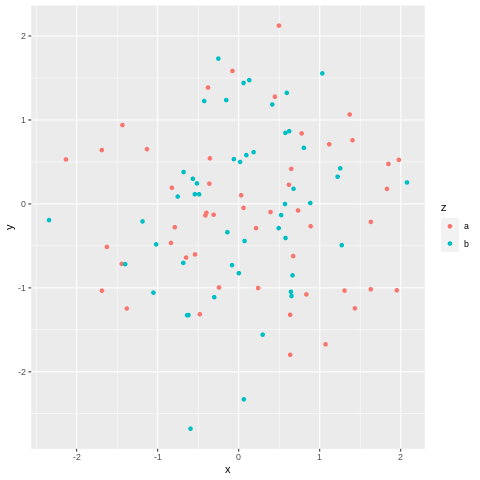

In [28]:
%%R
df <- tibble(x = rnorm(100), y = rnorm(100), z = rep(c('a', 'b'), 50))
ggplot(df) +
    geom_point(aes(x, y, color = z))
